In [137]:
import matplotlib.pyplot as plt
import numpy as np
import typing as tp
import scipy.ndimage
import astropy.units as u
import astropy.constants as const
import astropy.visualization
astropy.visualization.quantity_support()

def rotate(array, angle) -> tp.Tuple[np.ndarray]:
    rot_array = scipy.ndimage.rotate(array, angle, reshape=False)
    return rot_array

## Calculate results of Petschek reconnection

In [199]:
# Constants
mu_0 = const.mu0                # Magnetic constant
m_p = const.m_p                 # Proton mass
m_si = 4.6636*10**(-26)*u.kg    # Atomic mass silicon
k_B = const.k_B                 # Boltzmann constant


# Parameters
zeta = 30*u.deg         # Angle of initial field lines
gamma = 5/3             # Ratio of specific heats

# Internal properties
# B_i = 1
# rho_i = 1
# p_i = 1

# External properties
B_e = 1.5*u.mT
n_e = 3e14*u.m**(-3)    # Proton number density
rho_e = m_p * n_e
T_e = 2*u.MK
v_ae = (B_e/np.sqrt(mu_0 * rho_e)).to(u.km/u.s)
TA_e = ((m_p/k_B) * (v_ae**2)/2).to(u.MK)
beta_e = T_e/TA_e
p_e = (beta_e * ((B_e**2)/(2 * mu_0))).to(u.kg/(u.km * u.s**2))

# Section 1
rho_1 = rho_e
p_1 = p_e
v_x1 = 0
v_z1 = 0

# Section 2
rho_2 = rho_1
p_2 = p_1
T_2 = ((p_2/rho_2) * (m_p/k_B)).to(u.MK)
v_x2 = -2 * v_ae * np.sin(zeta/2)**2
v_z2 = -v_ae * np.sin(zeta)

# GDS properties
M_2 = np.sqrt(8/(gamma * beta_e)) * np.sin(zeta/2)**2
v_s = np.abs(v_x2) * (np.sqrt(M_2**(-2) + ((gamma + 1)**2)/16) - (3 - gamma)/4)

# Section 3
beta_3 = beta_e * (1 + gamma * M_2**2 * (1 + v_s/np.abs(v_x2)))
rho_3 = rho_2 * (1 + (np.abs(v_x2)/v_s))
T_3 = TA_e * beta_3 * rho_e/rho_3
v_x3 = 0
v_z3 = v_z2

## Spectral Synthesis

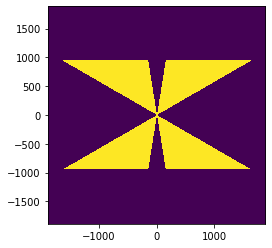

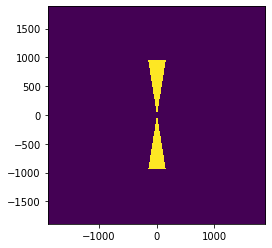

In [135]:
# Create masks for sections 2 and 3 separated by shocks.
t = 1*u.s   # Time that has passed (arbitrary)
v_xae = v_ae * np.cos(zeta)
v_zae = -v_ae * np.sin(zeta)
phi = (np.arctan(v_s/np.abs(v_zae))).to(u.deg)

nx = int(np.floor(np.abs(v_xae.value)))
nz = int(np.floor(np.abs(v_zae.value)))
x_lim_lo = -t * v_xae
x_lim_hi = t * v_xae
z_lim_lo = t * v_zae
z_lim_hi = -t * v_zae
x = np.linspace(x_lim_lo, x_lim_hi, num=nx)
z = np.linspace(z_lim_lo, z_lim_hi, num=nz)
xv, zv = np.meshgrid(x, z)
dx = (x[-1] - x[0])/nx
dz = (z[-1] - z[0])/nz

# Lines representing shocks
z1 = xv * np.tan(zeta)
z2 = xv * np.tan(90*u.deg - phi)

# Masks
mask_2 = np.zeros((nz, nx))
ind = np.logical_and(np.abs(z1) < np.abs(zv), np.abs(zv) < np.abs(z2))
mask_2[ind] = 1
mask_3 = np.zeros((nz, nx))
mask_3[np.abs(zv) > np.abs(z2)] = 1

# Pad masks so they may be rotated and not have necessary information rotate out of frame
x_pad = int(np.ceil((np.sqrt(len(x)**2 + len(z)**2) - len(x))/2))
z_pad = int(np.ceil((np.sqrt(len(x)**2 + len(z)**2) - len(z))/2))
mask_2p = np.pad(mask_2, [(z_pad, z_pad), (x_pad, x_pad)], mode='constant')
mask_3p = np.pad(mask_3, [(z_pad, z_pad), (x_pad, x_pad)], mode='constant')

# New x and z ranges
x_new = dx * (-mask_2p.shape[1]//2 + np.arange(mask_2p.shape[1]))
z_new = dz * (-mask_2p.shape[0]//2 + np.arange(mask_2p.shape[0]))

# Plot masks
plt.imshow(mask_2p, extent=[x_new.min().value, x_new.max().value, z_new.min().value, z_new.max().value])
plt.figure()
plt.imshow(mask_3p, extent=[x_new.min().value, x_new.max().value, z_new.min().value, z_new.max().value])

In [291]:
# Rotation parameters

num_ang = 32    # Number of unique angles to sample
# ang = np.linspace(0, 360, num_ang, endpoint=False)
ang = np.linspace(0, 1.5, num_ang)

In [259]:
# Only use if interested in intensity as a function of position along x...

# field_2_array = np.empty((0, *mask_2p.shape))
# field_3_array = np.empty((0, *mask_3p.shape))
# 
# for angle in ang:
#     field_2 = rotate(mask_2p, angle)
#     field_3 = rotate(mask_3p, angle)
#     field_2_array = np.append(field_2_array, [field_2], axis=0)
#     field_3_array = np.append(field_3_array, [field_3], axis=0)
# 
# # Plots of rotated density fields
# plt.imshow(field_2_array[5, :, :], extent=[x_new.min().value, x_new.max().value, z_new.min().value, z_new.max().value])
# plt.figure()
# plt.imshow(field_3_array[5, :, :], extent=[x_new.min().value, x_new.max().value, z_new.min().value, z_new.max().value])
# 
# # Integrate down columns to get density along x (not really needed...)
# 
# rhox_2 = np.sum(field_2_array[5, :, :], axis=0)
# rhox_3 = np.sum(field_3_array[5, :, :], axis=0)
# plt.plot(x_new, rhox_2)
# plt.figure()
# plt.plot(x_new, rhox_3)

In [292]:
# Total area in each section:
Vol_2 = np.sum(mask_2p) * dx * dz * 1*u.km
Vol_3 = np.sum(mask_3p) * dx * dz * 1*u.km

# Intensity from each section
I_2 = (rho_2**2 * Vol_2).to(u.kg**2/u.km**3)
I_3 = (rho_3**2 * Vol_3).to(u.kg**2/u.km**3)

# Amplitudes
amp_2 = I_2
amp_3 = I_3

# Velocities along line of sight after rotation (LOS = z dir)
# Section 2 (right)
v_z2R_los = v_z2 * np.cos(ang)
v_x2R_los = v_x2 * np.sin(ang)
peak_2R = v_z2R_los + v_x2R_los

# Section 2 (left)
v_z2L_los = v_z2 * np.cos(ang)
v_x2L_los = -v_x2 * np.sin(ang)
peak_2L = v_z2L_los + v_x2L_los

# Section 3
peak_3 = v_z3 * np.cos(ang)

In [293]:
v_range = np.linspace(v_z3 - (200*u.km/u.s), -v_z3 + (200*u.km/u.s), num=200)
v_range = np.expand_dims(v_range, 1)

# Section 2 spectral lines
v_th2 = (np.sqrt(k_B * T_2/m_si)).to(u.km/u.s)  # Thermal speed of silicon in section 2

# Model thermally broadened spectral lines from section 2
line_lo2R = amp_2 * np.exp(-((v_range - peak_2R)**2)/(2 * v_th2**2))
line_hi2R = amp_2 * np.exp(-((v_range + peak_2R)**2)/(2 * v_th2**2))
lines_2R = line_lo2R + line_hi2R

line_lo2L = amp_2 * np.exp(-((v_range - peak_2L)**2)/(2 * v_th2**2))
line_hi2L = amp_2 * np.exp(-((v_range + peak_2L)**2)/(2 * v_th2**2))
lines_2L = line_lo2L + line_hi2L

# Section 3 spectral lines
v_th3 = (np.sqrt(k_B * T_3/m_si)).to(u.km/u.s)  # Thermal speed of silicon in section 3

# Model thermally broadened spectral lines from section 2
line_lo3 = amp_3 * np.exp(-((v_range - peak_3)**2)/(2 * v_th3**2))
line_hi3 = amp_3 * np.exp(-((v_range + peak_3)**2)/(2 * v_th3**2))
lines_3 = line_lo3 + line_hi3

spectrum = lines_2R + lines_2L + lines_3

c:\users\cappy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
c:\users\cappy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
c:\users\cappy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed an

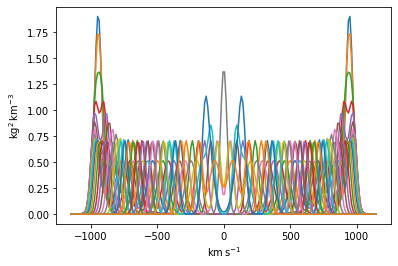

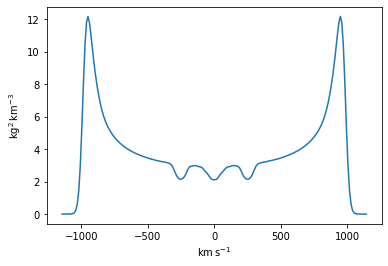

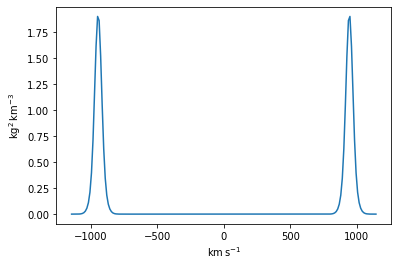

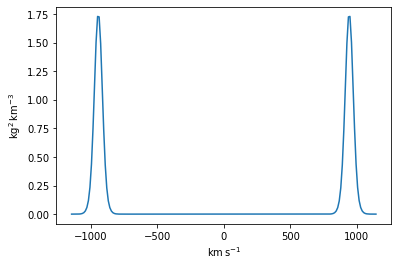

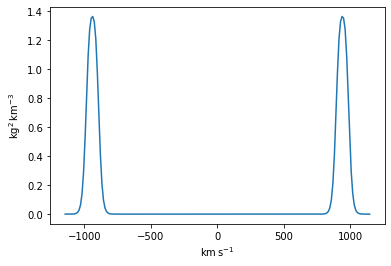

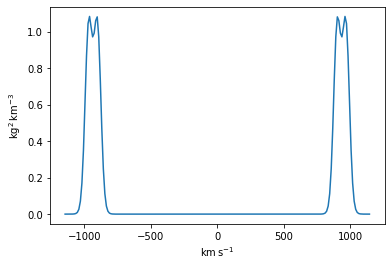

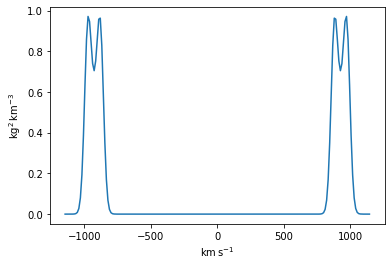

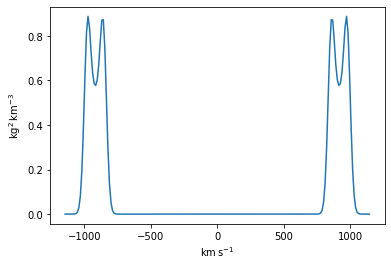

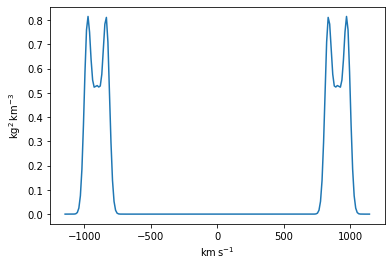

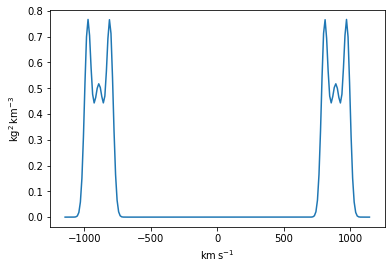

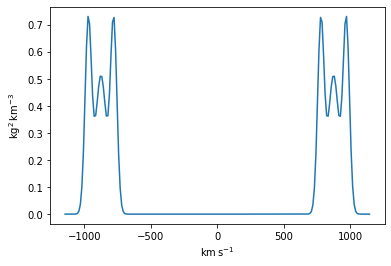

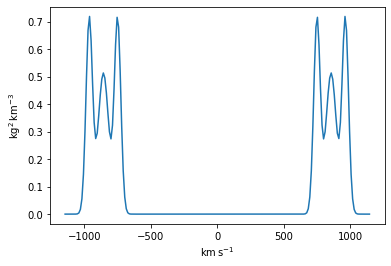

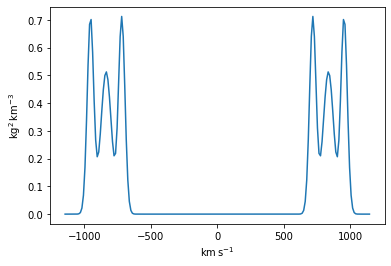

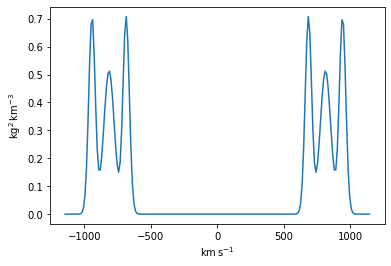

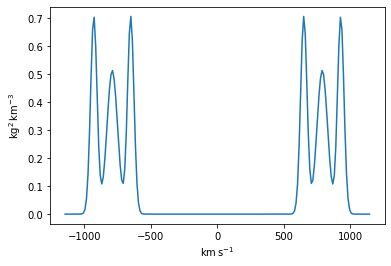

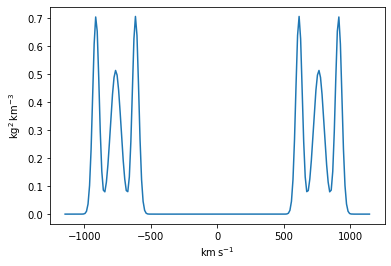

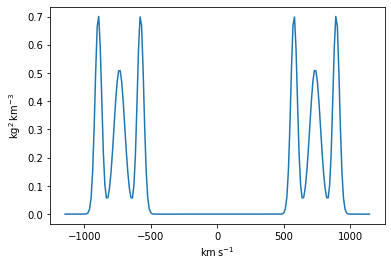

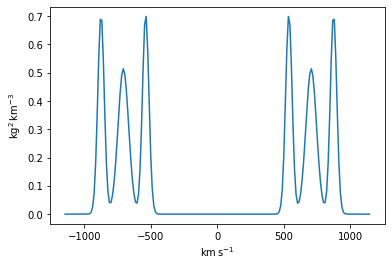

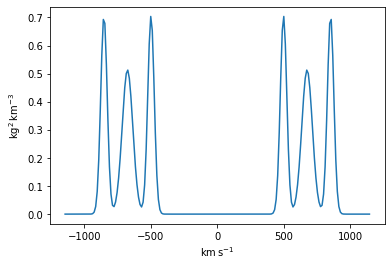

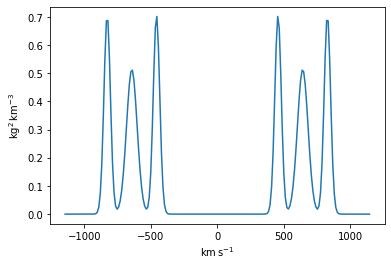

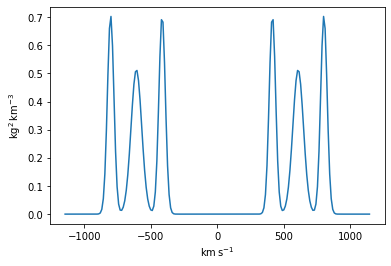

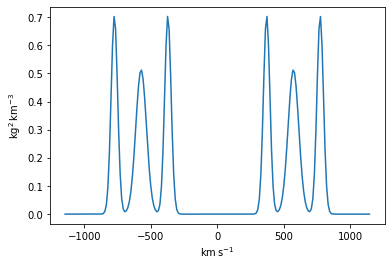

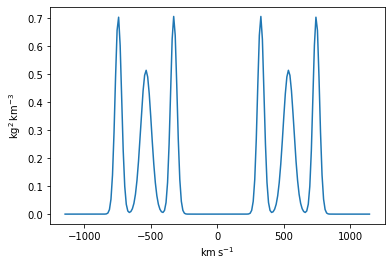

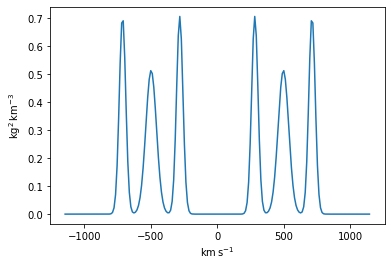

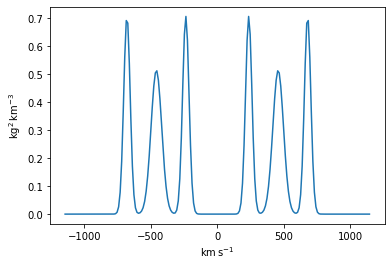

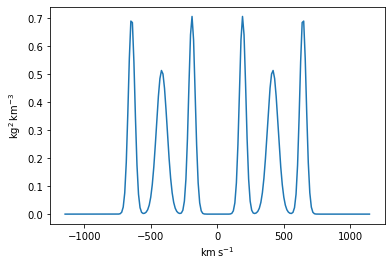

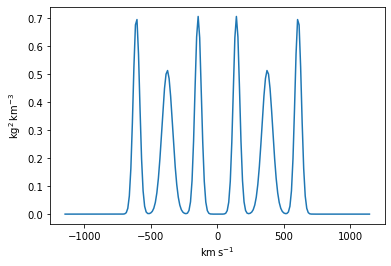

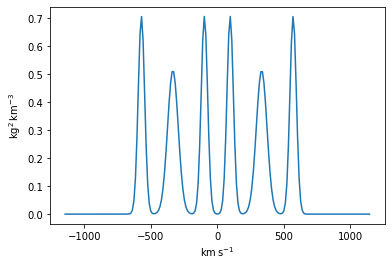

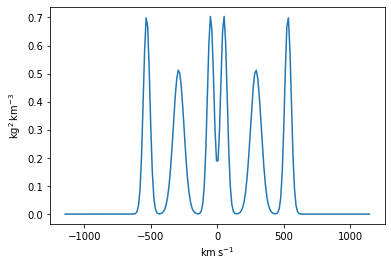

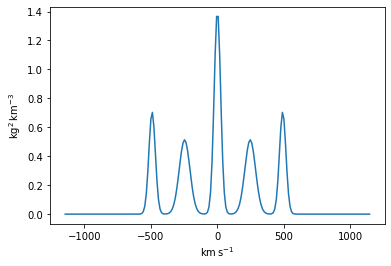

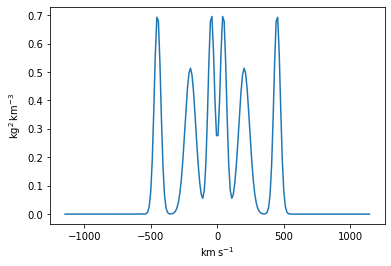

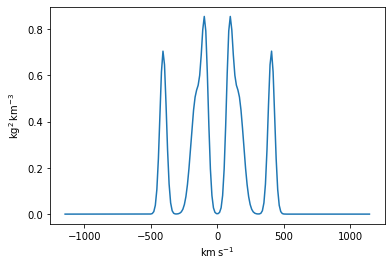

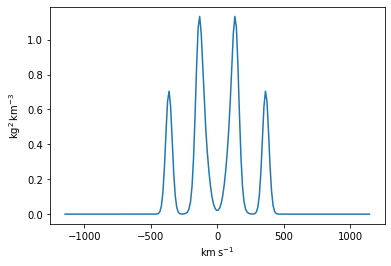

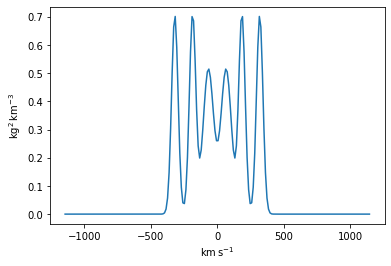

In [294]:
plt.plot(v_range, spectrum)
plt.figure()
_ = plt.plot(v_range, np.sum(spectrum, axis=1))
plt.figure()
plt.plot(v_range, spectrum[:,0])
plt.figure()
plt.plot(v_range, spectrum[:,1])
plt.figure()
plt.plot(v_range, spectrum[:,2])
plt.figure()
plt.plot(v_range, spectrum[:,3])
plt.figure()
plt.plot(v_range, spectrum[:,4])
plt.figure()
plt.plot(v_range, spectrum[:,5])
plt.figure()
plt.plot(v_range, spectrum[:,6])
plt.figure()
plt.plot(v_range, spectrum[:,7])
plt.figure()
plt.plot(v_range, spectrum[:,8])
plt.figure()
plt.plot(v_range, spectrum[:,9])
plt.figure()
plt.plot(v_range, spectrum[:,10])
plt.figure()
plt.plot(v_range, spectrum[:,11])
plt.figure()
plt.plot(v_range, spectrum[:,12])
plt.figure()
plt.plot(v_range, spectrum[:,13])
plt.figure()
plt.plot(v_range, spectrum[:,14])
plt.figure()
plt.plot(v_range, spectrum[:,15])
plt.figure()
plt.plot(v_range, spectrum[:,16])
plt.figure()
plt.plot(v_range, spectrum[:,17])
plt.figure()
plt.plot(v_range, spectrum[:,18])
plt.figure()
plt.plot(v_range, spectrum[:,19])
plt.figure()
plt.plot(v_range, spectrum[:,20])
plt.figure()
plt.plot(v_range, spectrum[:,21])
plt.figure()
plt.plot(v_range, spectrum[:,22])
plt.figure()
plt.plot(v_range, spectrum[:,23])
plt.figure()
plt.plot(v_range, spectrum[:,24])
plt.figure()
plt.plot(v_range, spectrum[:,25])
plt.figure()
plt.plot(v_range, spectrum[:,26])
plt.figure()
plt.plot(v_range, spectrum[:,27])
plt.figure()
plt.plot(v_range, spectrum[:,28])
plt.figure()
plt.plot(v_range, spectrum[:,29])
plt.figure()
plt.plot(v_range, spectrum[:,30])
plt.figure()
plt.plot(v_range, spectrum[:,31])

In [286]:
print(ang[20])

1.3377926421404682
